In [11]:
import os
import glob
import time
from datetime import datetime

import torch
import numpy as np
import pandas as pd

from State import State
from GenerateDemandMonthly import GenerateDemandMonthly

from PPO import PPO

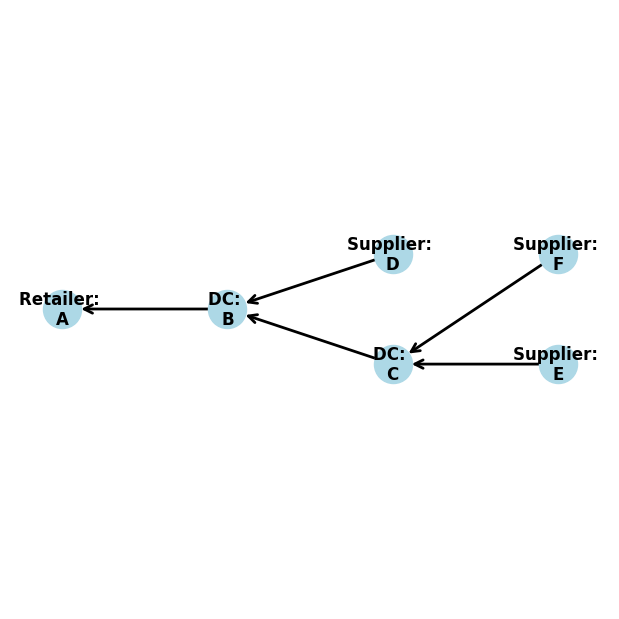

In [12]:
env = State()
env.create_state([-1, 0, 1, 1, 2, 2])
env.show_network()

In [13]:
has_continuous_action_space = False # continuous action space; else discrete
action_std = 0.6            # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.03       # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.03               # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = int(1e5)  # action_std decay frequency (in num timesteps
eps_clip = 0.2          # clip parameter for PPO
gamma = 0.99            # discount factor
K_epochs = 20
lr_actor = 0.00005      # learning rate for actor network
lr_critic = 0.0001       # learning rate for critic network

random_seed = 1234         # set random seed if required (0 = no random seed)

state_dim = 6
action_dim = 512

In [14]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)

ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)
ppo_agent.policy_old.load_state_dict(torch.load("rlmodel.pt"))
ppo_agent.policy.load_state_dict(torch.load("rlmodel.pt"))

<All keys matched successfully>

In [ ]:
#### Generate New Demand ####
demand_generator = GenerateDemandMonthly()

df = pd.read_csv("../src/TOTALSA.csv")
mean = df['TOTALSA'].mean()
std = df['TOTALSA'].std()
period = 108
iterations = 100

demand_matrix = np.reshape(demand_generator.simulate_normal_no_season(\
            periods = period * iterations, mean=mean, std=std),\
                (iterations, period))

In [ ]:
reward_RL = []

for demand_list in demand_matrix:
    reward_total = 0
    state = env.reset()
    env.set_demand_list(demand_list)
    done = False
    reward_sub = 0
    
    while not done:
        action = ppo_agent.select_action(state)
        state, reward, done = env.step(action)
        reward_sub += reward
        if done:
            break
    reward_total += reward_sub
    reward_RL.append(reward_total)
        

In [15]:
reward_RL = []
for demand in demand_test:
    reward_total = 0
    for i in range(2):
        env = MultiEchelonInvOptEnv(demand[i*2:i*2+2])
        state = env.reset()
        done = False
        reward_sub = 0
        while not done:
            action = ppo_agent.select_action(state)
            state, reward, done = env.step(action)
            reward_sub += reward
            if done:
                break
        reward_total += reward_sub
    reward_RL.append(reward_total)

NameError: name 'demand_test' is not defined